# Can we use hessian to estimate steepness of a minima?


Joint work with Sam Laf.


### Setting things up


In [0]:
# Importing required libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn 
import torch.nn.functional as F

In [0]:
import autograd.numpy as np
from autograd import grad  
from autograd import elementwise_grad as egrad

In [0]:
!git clone https://github.com/mariogeiger/hessian
# !ls
%cd /content/hessian
!python setup.py install

Cloning into 'hessian'...
remote: Enumerating objects: 168, done.
remote: Total 168 (delta 0), reused 0 (delta 0), pack-reused 168
Receiving objects: 100% (168/168), 26.77 KiB | 1.27 MiB/s, done.
Resolving deltas: 100% (73/73), done.
/content/hessian
running install
running bdist_egg
running egg_info
creating hessian.egg-info
writing hessian.egg-info/PKG-INFO
writing dependency_links to hessian.egg-info/dependency_links.txt
writing top-level names to hessian.egg-info/top_level.txt
writing manifest file 'hessian.egg-info/SOURCES.txt'
writing manifest file 'hessian.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/hessian
copying hessian/hessian.py -> build/lib/hessian
copying hessian/__init__.py -> build/lib/hessian
copying hessian/power_method.py -> build/lib/hessian
copying hessian/gradient.py -> build/lib/hessian
copying hessian/rayleigh_quotient.py -> build/lib/hessi

In [0]:
from hessian import hessian

### Finding the gradient for a simple function

In [0]:
# Creating the loss function
x = torch.Tensor(np.array([0, 1, -1, -3]))
x.requires_grad = True
loss = x.dot(x)

# Find grad**2 of loss wrt x
k = loss.mean()
k.backward(retain_graph=True)
# print(x.grad)

# Finding hessian of loss wrt x
h = hessian(k, x, create_graph=True)
print(h)

tensor([[2., 0., 0., 0.],
        [0., 2., 0., 0.],
        [0., 0., 2., 0.],
        [0., 0., 0., 2.]])


In [0]:
# Using autograd to compute second derivative
def loss(x):
  y = np.power(x,2)
  return y

hessian = grad(grad(loss))
hessian(0.0)

2.0

### Finding the gradient for a harder function

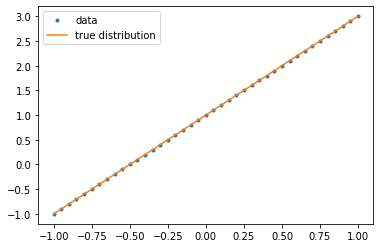

(<matplotlib.legend.Legend at 0x7fb87be19198>, None)

In [0]:
# Generating the data
x = np.arange(-1, 1.01, .05)
noise = np.random.randn(x.shape[0])
f_true = 2 * x + 1
y = f_true

# Plotting the data
plt.plot(x, y, '.', label='data')
plt.plot(x, f_true, '-', label='true distribution')
plt.legend(), plt.show()

In [0]:
# Create a pytorch class for a linear network 
class LinearNet(nn.Module):
  def __init__(self, in_size=1, out_size=1):
    super(LinearNet, self).__init__()
    self.layer = nn.Linear(in_size, out_size)

    # Setting init parameters of the network
    self.layer.weight.data.fill_(0)
    self.layer.bias.data.fill_(0)

  def forward(self, x):
    y = self.layer(x)
    return y

data shapes:  torch.Size([41, 1]) torch.Size([41, 1])
2.0989455833120285e-12


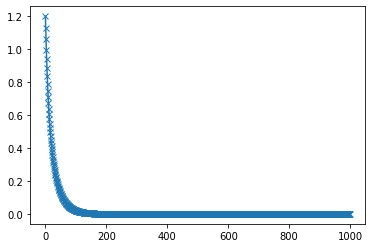

In [0]:
x_torch = torch.from_numpy(x.T).unsqueeze(1).float()
y_torch = torch.from_numpy(y).unsqueeze(1).float()
print('data shapes: ', x_torch.size(), y_torch.size())

# Learn the network on the dataset
model = LinearNet()
optimizer = torch.optim.SGD(model.parameters(), lr=5e-2)
loss_vec = []
weights = []
weight_grads = []
max_iters = 1000

for t in range(max_iters):
    
    y_pred = model(x_torch)

    # Compute and print loss
    loss = (y_pred - y_torch).pow(2).mul(0.5).mean()
    
    loss_vec.append(loss.item())

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward(retain_graph=(t == max_iters-1))
    if(not t == max_iters-1):
      optimizer.step()
    
    # Storing data into a dataset
    weights.append([model.layer.weight[0][0].tolist(), model.layer.bias[0].tolist()])
    grad_w = model.layer.weight.grad.numpy()[0][0] # Storing gradient for w
    grad_b = model.layer.bias.grad.numpy()[0] # Storing gradient for b
    weight_grads.append([grad_w, grad_b])

# loss.backward()

weights = np.array(weights)
weight_grads = np.array(weight_grads)

plt.plot(loss_vec, '-x')
print(loss_vec[-1])

In [0]:
# Compute hessian of loss at w*
h = hessian(loss, [model.layer.weight, model.layer.bias], create_graph=True)

In [0]:
print(h)

tensor([[ 3.5000e-01, -5.5879e-09],
        [-5.5879e-09,  1.0000e+00]], grad_fn=<CopySlices>)


In [0]:
np.mean(x), np.mean(x**2)

(8.881784197001252e-16, 0.35000000000000064)

The estimate of hessian is inline with analytic calculations done by Sam Laf. :)

### Let's compute the hessian for MNIST data next

In [0]:
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable
import numpy as np
from tqdm.notebook import tqdm as tqdm
import matplotlib.pyplot as plt

In [0]:
input_size = 784 # img_size = (28,28) ---> 28*28=784 in total
hidden_size = 500 # number of nodes at hidden layer
num_classes = 10 # number of output classes discrete range [0,9]
num_epochs = 2 # number of times which the entire dataset is passed throughout the model
batch_size = 64  # the size of input data took for one iteration
lr = 1e-3 # size of step

In [0]:
train_data = dsets.MNIST(root = './data', train = True,
                        transform = transforms.ToTensor(), download = True)

test_data = dsets.MNIST(root = './data', train = False,
                       transform = transforms.ToTensor())

In [0]:
train_gen = torch.utils.data.DataLoader(dataset = train_data,
                                             batch_size = batch_size,
                                             shuffle = True)

test_gen = torch.utils.data.DataLoader(dataset = test_data,
                                      batch_size = batch_size, 
                                      shuffle = False)

In [0]:
class Net(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes):
    super(Net,self).__init__()
    self.fc1 = nn.Linear(input_size, hidden_size)
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(hidden_size, num_classes)
  
  def forward(self,x):
    out = self.fc1(x)
    out = self.relu(out)
    out = self.fc2(out)
    return out

In [0]:
net = Net(input_size, hidden_size, num_classes)
if torch.cuda.is_available():
  net.cuda()

In [0]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam( net.parameters(), lr=lr)

In [33]:
for epoch in range(num_epochs):
  for i ,(images,labels) in enumerate(train_gen):
    images = Variable(images.view(-1,28*28))
    labels = Variable(labels)
    
    optimizer.zero_grad()
    outputs = net(images)
    loss = loss_function(outputs, labels)
    loss.backward()
    optimizer.step()
    
    if (i+1) % 100 == 0:
      print('Epoch [%d/%d], Step [%d/%d], Loss: %.4f'
                 %(epoch+1, num_epochs, i+1, len(train_data)//batch_size, loss.item()))

Epoch [1/2], Step [100/937], Loss: 0.5627
Epoch [1/2], Step [200/937], Loss: 0.3659
Epoch [1/2], Step [300/937], Loss: 0.1140
Epoch [1/2], Step [400/937], Loss: 0.1915
Epoch [1/2], Step [500/937], Loss: 0.1435
Epoch [1/2], Step [600/937], Loss: 0.1805
Epoch [1/2], Step [700/937], Loss: 0.1685
Epoch [1/2], Step [800/937], Loss: 0.0549
Epoch [1/2], Step [900/937], Loss: 0.1727
Epoch [2/2], Step [100/937], Loss: 0.1467
Epoch [2/2], Step [200/937], Loss: 0.1673
Epoch [2/2], Step [300/937], Loss: 0.1054
Epoch [2/2], Step [400/937], Loss: 0.1461
Epoch [2/2], Step [500/937], Loss: 0.0593
Epoch [2/2], Step [600/937], Loss: 0.0617
Epoch [2/2], Step [700/937], Loss: 0.2250
Epoch [2/2], Step [800/937], Loss: 0.0388
Epoch [2/2], Step [900/937], Loss: 0.0665


In [0]:
correct = 0
total = 0

for images,labels in train_gen:
  images = images.view(-1,28*28)
  labels = labels
  
  output = net(images)
  _, predicted = torch.max(output,1)
  correct += (predicted == labels).sum()
  total += labels.size(0)
train_acc = (100*correct.numpy())/(total+1)
print('Train accuracy of the model: %.3f %%' %(train_acc))
print(correct, total)

correct = 0
total = 0
for images,labels in test_gen:
  images = images.view(-1,28*28)
  labels = labels
  
  output = net(images)
  _, predicted = torch.max(output,1)
  correct += (predicted == labels).sum()
  total += labels.size(0)
test_acc = (100*correct.numpy())/(total+1)
print('Test accuracy of the model: %.3f %%' %(test_acc))
print(correct, total)


In [34]:
784*500+500*10

397000